In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.preprocessing import image
from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.transform import resize


Using TensorFlow backend.


58892288/58889256 [==============================] - 5s 0us/step
iteration=0, loss=2980.836181640625
iteration=1, loss=779.3160400390625
iteration=2, loss=467.8676452636719
iteration=3, loss=356.1100158691406
iteration=4, loss=280.8711242675781
iteration=5, loss=231.16531372070312
iteration=7, loss=174.6449432373047
iteration=8, loss=158.70013427734375
iteration=9, loss=146.71063232421875
iteration=10, loss=138.45101928710938
iteration=11, loss=131.35040283203125
iteration=12, loss=125.99346923828125
iteration=13, loss=121.33562469482422
iteration=14, loss=118.28321838378906
iteration=15, loss=114.56867980957031
iteration=16, loss=111.39401245117188
iteration=17, loss=108.58708190917969
iteration=18, loss=106.23411560058594
iteration=19, loss=103.97654724121094
iteration=20, loss=102.19292449951172
iteration=21, loss=100.37134552001953
iteration=22, loss=98.87104034423828
iteration=23, loss=97.19721984863281
iteration=24, loss=95.8924331665039
iteration=25, loss=94.498291015625
iterati

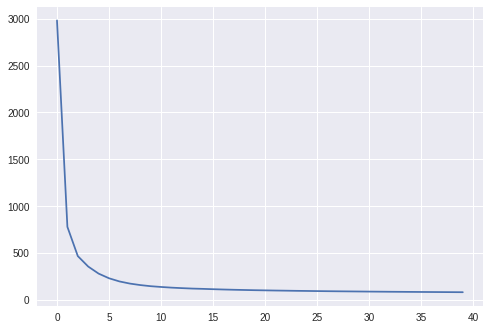

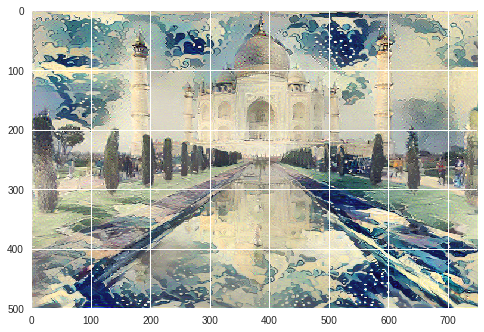

In [3]:
def VGG16_AveragePool(shape):
    '''Recreate the vgg network with avg pooling instead of max pooling applied in vgg16 network.We apply average 
    pooling to retain the integrity of certain features.Max pooling throws certain features away.'''
    
    vgg = VGG16(input_shape=shape,weights='imagenet',include_top=False)
    new_model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
    return new_model

def VGG16_AveragePool_Cutoff(shape, conv_layer_number):
    '''To use any layer in the new model(VGG) to produce content image's activations for further use. '''
    '''Returns the new model (new CNN) with conv_layer_number number of layers.'''
    
    if conv_layer_number<1 and conv_layer_number>13:
        print("VGG network has 13 layers only.")
        return None
    model = VGG16_AveragePool(shape)
    new_model = Sequential()
    num_layers = 0
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            num_layers += 1
        new_model.add(layer)
        if num_layers >= conv_layer_number:
            break
    model.summary()
    return new_model

def BGR_RBG_unpreprocess(img):
    '''VGG by default deals with BGR images but matplotlib requires the images to be RBG'''
    img[...,0] += 103.939
    img[...,1] += 116.779
    img[...,2] += 126.68
    img = img[...,::-1]
    return img

def scale(x):
    x = x - x.min()
    x = x / x.max()
    return x

def gram_matrix(img):
    '''Input: img dimensions are [H,W,C].This function first converts the input tensor to matrix of dim [C,H*W] and
    computes the gram matrix by multiplying the flattened matrix with its transpose'''
    
    img_to_matrix = K.batch_flatten(K.permute_dimensions(img,(2,0,1)))
    G = K.dot(img_to_matrix,K.transpose(img_to_matrix)) / img.get_shape().num_elements()
    return G

def compute_style_loss(style_img, new_img):
    return K.mean(K.square(gram_matrix(style_img) - gram_matrix(new_img)))

def minimize(fn, epochs, batch_shape):
    t0 = datetime.now()
    x = np.random.randn(np.prod(batch_shape))
    losses = []
    for i in range(epochs):
        x, l,_ = fmin_l_bfgs_b(func=fn,x0=x,maxfun=20)
        x = np.clip(x,-127,127)
        print("iteration=%s, loss=%s" %(i,l))
        losses.append(l)

    print("time:",datetime.now() - t0)
    plt.plot(losses)
    plt.show()

    new_image = x.reshape(*batch_shape)
    final_image = BGR_RBG_unpreprocess(new_image)

    return final_image[0]

def load_image(path,shape=None):
    img = image.load_img(path, target_size=shape)
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    return img_array


content_image = load_image('taj_mahal.jpg')
height, width = content_image.shape[1:3]
style_image = load_image('wave.jpg',(height,width))
batch_shape = content_image.shape
shape = content_image.shape[1:]

vgg_model = VGG16_AveragePool(shape)

content_model = Model(vgg_model.input, vgg_model.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_image),name='content_target')

conv_outputs = [
                layer.get_output_at(1) for layer in vgg_model.layers \
                if layer.name.endswith('conv1')
]
style_model = Model(vgg_model.input, conv_outputs)
style_outputs = [K.variable(y) for y in style_model.predict(style_image)]
style_weights = [0.2,0.4,0.3,0.5,0.2]

loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights,conv_outputs,style_outputs):
    loss += w*compute_style_loss(symbolic[0],actual[0])
    
gradients = K.gradients(loss, vgg_model.input)
get_loss_and_gradients = K.function(inputs=[vgg_model.input],outputs=[loss] + gradients)

def get_loss_and_gradients_wrapper(x):
    l,g = get_loss_and_gradients([x.reshape(*batch_shape)])
    return l.astype(np.float64),g.flatten().astype(np.float64)

final_image = minimize(get_loss_and_gradients_wrapper,40,batch_shape)
plt.imshow(scale(final_image))
plt.show()
